In [3]:
from trainer import QLearn
import gymnasium as gym

EPISODES = 1000000

env = gym.make("Blackjack-v1", render_mode="rgb_array")

q_learn = QLearn(env, alpha=0.1, gamma=1, epsilon=1, epsilon_decay=0.999995, min_epsilon=0.01)
rewards = q_learn.train(episodes=EPISODES, stats_interval=50000)

New max of 1.0 in episode 1
Episodes (0, 49999): Avg Reward- -0.36658 Epsilon- 0.7788002963181708
Episodes (50000, 99999): Avg Reward- -0.30898 Epsilon- 0.6065299015452864
Episodes (100000, 149999): Avg Reward- -0.27262 Epsilon- 0.472365667049309
Episodes (150000, 199999): Avg Reward- -0.23386 Epsilon- 0.3678785214685313
Episodes (200000, 249999): Avg Reward- -0.20406 Epsilon- 0.2865039015287838
Episodes (250000, 299999): Avg Reward- -0.19216 Epsilon- 0.22312932340693056
Episodes (300000, 349999): Avg Reward- -0.18724 Epsilon- 0.17377318318659052
Episodes (350000, 399999): Avg Reward- -0.175 Epsilon- 0.13533460655786997
Episodes (400000, 449999): Avg Reward- -0.16918 Epsilon- 0.1053986316893728
Episodes (450000, 499999): Avg Reward- -0.16386 Epsilon- 0.08208448559121344
Episodes (500000, 549999): Avg Reward- -0.15076 Epsilon- 0.06392742170156093
Episodes (550000, 599999): Avg Reward- -0.15156 Epsilon- 0.04978669496403203
Episodes (600000, 649999): Avg Reward- -0.15502 Epsilon- 0.038773

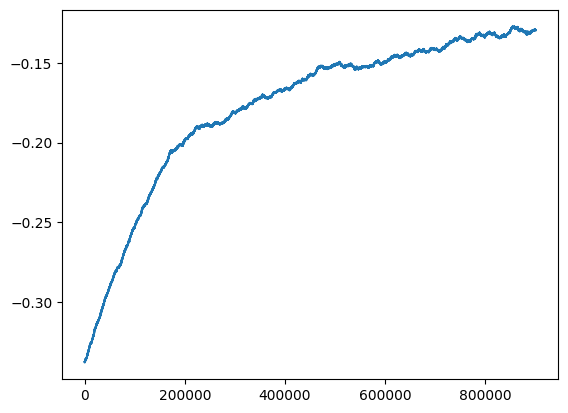

In [4]:
import matplotlib.pyplot as plt
from trainer import moving_average

plt.figure()
plt.plot(moving_average(rewards, int(EPISODES/10)))

In [5]:
from IPython.display import HTML

HTML(q_learn.playback())

Playback Return: 0.0


In [7]:
q_learn.eval(episodes=100000)

Average Return over 100000 episodes: -0.12601


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import deque

class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [2]:
from trainer import DDQN
import gymnasium as gym
EPISODES = 200
env = gym.make("CartPole-v1", render_mode="rgb_array")
ddqn = DDQN(env, QNetwork, buffer_size=100000, batch_size=32,
                    gamma=0.99, lr=1e-3, epsilon_start=1.0, 
                    epsilon_end=0.01, epsilon_decay=0.995,
                    target_update_interval=100)
rewards, losses = ddqn.train(episodes=EPISODES, stats_interval=50)

New max of 30.0 in episode 1
New max of 33.0 in episode 10
New max of 38.0 in episode 11
New max of 50.0 in episode 19
New max of 75.0 in episode 21
New max of 79.0 in episode 44
Episodes (0, 49): Avg Reward- 27.88 Epsilon- 0.778312557068642
New max of 126.0 in episode 58
Episodes (50, 99): Avg Reward- 45.12 Epsilon- 0.6057704364907278
New max of 205.0 in episode 108
New max of 288.0 in episode 120
Episodes (100, 149): Avg Reward- 78.7 Epsilon- 0.47147873742168567
Episodes (150, 199): Avg Reward- 65.5 Epsilon- 0.3669578217261671


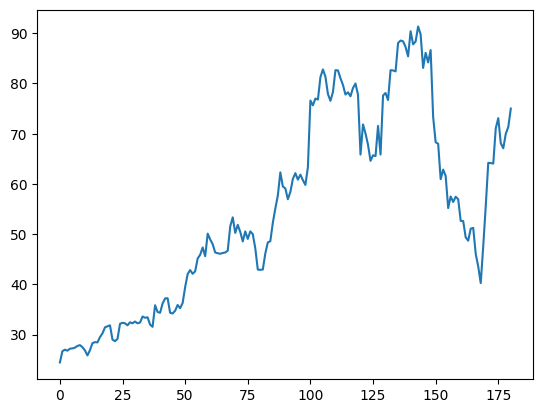

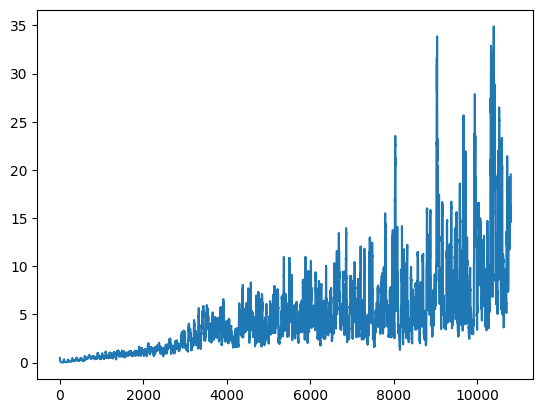

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

plt.figure()
plt.plot(moving_average(rewards, int(EPISODES/10)))
plt.figure()
plt.plot(moving_average(losses, int(EPISODES/10)))

In [4]:
from IPython.display import HTML

HTML(ddqn.playback())

Playback Return: 186.0


In [5]:
ddqn.eval(episodes=100)

Average Return over 100 episodes: 184.43


In [24]:
import torch.nn as nn
import torch
import numpy as np
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        
        self.actor = nn.Sequential(
            nn.Linear(128, 2),
            nn.Softmax()
        )
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.actor(x), self.critic(x)

In [ ]:
class A2C():
    def __init__(self, env, actor_critic, optimizer, gamma):
        self.env = env

        self.actor_critic = actor_critic
        self.optimizer = optimizer
        self.gamma = gamma
        self.critic_loss_fn = nn.MSELoss()
    
    def sample_action(self, observation):
        obs_tensor = torch.from_numpy(np.array(observation)).unsqueeze(0).float()
        probs, value = self.actor_critic(obs_tensor)
        return probs, torch.multinomial(probs, num_samples=1).item(), value.item()
    
    def train(self, episodes, stats_interval):
        losses = []
        rewards = []
        max_reward = 0

        for e in range(episodes):
            observation, _ = self.env.reset()

            log_probs = []
            values = []
            episode_rewards = []
            total_episode_reward = 0

            episode_over = False
            while not episode_over:

                probs, action, value = self.sample_action(observation)
                observation, reward, terminated, truncated, _ = self.env.step(action)

                log_probs.append(torch.log(probs[0, action]))
                values.append(value)

                episode_rewards.append(reward)
                total_episode_reward += reward

                episode_over = terminated or truncated
            
            rewards.append(total_episode_reward)
            if total_episode_reward > max_reward:
                max_reward = total_episode_reward
                print(f"New max of {max_reward} in episode {e + 1}")

            returns = []
            R = 0
            for r in reversed(episode_rewards):
                R = r + self.gamma * R
                returns.insert(0, R)

            returns = torch.tensor(returns)
            if returns.size(dim=-1) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)
            
            values = torch.tensor(values)
            advantages = returns - values

            actor_loss = -(torch.sum(torch.tensor(log_probs) * advantages.detach()))
            critic_loss = self.critic_loss_fn(values, returns)

            loss = actor_loss + 0.5 * critic_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            losses.append(loss.item())

            if (e + 1) % stats_interval == 0:
                print(f"Episodes {(e - stats_interval + 1, e)}:", end=" ")
                print(f"Avg Loss- {sum(losses[e-stats_interval+1:e+1])/stats_interval}", end=" ")
                print(f"Avg Reward- {sum(rewards[e-stats_interval+1:e+1])/stats_interval}")
                
        self.env.close()

        self.episodes_trained += episodes

        return rewards, losses

In [49]:
import gymnasium as gym

EPISODES = 2000

env = gym.make("CartPole-v1", render_mode="rgb_array")

actor_critic = Model()
optimizer = torch.optim.Adam(actor_critic.parameters(), lr=1e-3)

reinforce = A2C(env, actor_critic, optimizer, gamma=0.99)
rewards, losses = reinforce.train(episodes=EPISODES, stats_interval=500)

New max of 17.0 in episode 1
tensor(-1.7277) tensor(1.0541)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn